# Investigating the Effect of MLP Depth and Width on Graph Isomorphism Network Oversquashing

Oxford Graph Representation Learning Miniproject Michaelmas 2024

Candidate Number: 1090443

# Imports

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torch_geometric
import torch_geometric.datasets as datasets
from torch_geometric.nn.conv import GINConv, GCNConv
from torch_geometric.nn import MLP
from torch_geometric.utils import dense_to_sparse
#from torch_geometric.data import Data, InMemoryDataset

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from google.colab import drive

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from typing import List
import os
import json
import time
import copy
import pickle

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch_geometric.seed_everything(42)

# Datasets

We use Cora and Chameleon. Cora is medium homophilic and Chameleon is medium heterophilic. This characterisation is from Topping et al. (2019) and uses the homophily index from Pei et al. (2019).

In [150]:
def split_mask(bigmask, ratio):
    # randomly split the mask into two masks
    # note that bigmask, mask1, mask2 all have the same length
    # bigmask = dataset.test_mask
    positive_indices = np.where(bigmask == 1)[0]
    bigmask_size = len(positive_indices) # number of ones in bigmask
    mask1_size = int(ratio * bigmask_size)
    mask2_size = bigmask_size - mask1_size

    selected_indices = np.random.choice(positive_indices, mask1_size, replace=False)

    mask1 = torch.zeros_like(bigmask)
    mask2 = torch.zeros_like(bigmask)
    mask1[selected_indices] = 1
    remaining_indices = np.setdiff1d(positive_indices, selected_indices)
    mask2[remaining_indices] = 1
    return mask1, mask2

cora_dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
bigmask = torch.ones((len(cora_dataset.y))).bool()
dev_mask, test_mask = split_mask(bigmask, ratio=0.8)
cora_dataset.dev_mask = dev_mask
cora_dataset.test_mask = test_mask
print(len(cora_dataset.y), len(cora_dataset.y[cora_dataset.dev_mask]), len(cora_dataset.y[cora_dataset.test_mask]))


2708 2166 542


In [125]:
chameleon_dataset = datasets.WikipediaNetwork(
    root='data/WikipediaNetwork',
    name='chameleon',
    transform=torch_geometric.transforms.GCNNorm(),
    )
cham_orig_train = chameleon_dataset.train_mask
cham_orig_val = chameleon_dataset.val_mask
cham_orig_test = chameleon_dataset.test_mask

chameleon_dataset.train_mask = cham_orig_train[:, 0]
chameleon_dataset.val_mask = cham_orig_val[:, 0]
chameleon_dataset.test_mask = cham_orig_test[:, 0]

bigmask = torch.ones((len(chameleon_dataset.y))).bool()
dev_mask, test_mask = split_mask(bigmask, ratio=0.8)
chameleon_dataset.dev_mask = dev_mask
chameleon_dataset.test_mask = test_mask
print(len(chameleon_dataset.y), len(chameleon_dataset.y[chameleon_dataset.dev_mask]), len(chameleon_dataset.y[chameleon_dataset.test_mask]))
#print(chameleon_dataset.data)

2277 1821 456


#GIN with variable parameter MLP

In [17]:
# Graph Isomorphism Network inspired by https://github.com/weihua916/powerful-gnns/tree/master/models

def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class CustomGIN(nn.Module):
    def __init__(self, ginparams):
        super(CustomGIN, self).__init__()
        assert ginparams["num_hidden_gin_layers"] > 0
        self.ginparams = ginparams
        dropout = 0.3
        ginlayers = []
        mlp = MLP(in_channels=ginparams["gin_input_dim"], hidden_channels=ginparams["mlp_hidden_dim"], out_channels=ginparams["gin_hidden_dim"], num_layers=ginparams["num_hidden_mlp_layers"], act="relu", dropout=dropout)
        gin = GINConv(nn=mlp, train_eps=True)
        ginlayers.append(gin)

        for i in range(1, ginparams["num_hidden_gin_layers"]):
            mlp = MLP(in_channels=ginparams["gin_hidden_dim"], hidden_channels=ginparams["mlp_hidden_dim"], out_channels=ginparams["gin_hidden_dim"], num_layers=ginparams["num_hidden_mlp_layers"], act="relu", dropout=dropout)
            gin = GINConv(nn=mlp, train_eps=True)
            ginlayers.append(gin)

        #final layer no activation
        mlp = MLP(in_channels=ginparams["gin_hidden_dim"], hidden_channels=ginparams["mlp_hidden_dim"], out_channels=ginparams["output_dim"], num_layers=ginparams["num_hidden_mlp_layers"], act=None, dropout=dropout)
        gin = GINConv(nn=mlp, train_eps=True)
        ginlayers.append(gin)
        self.ginlayers = nn.ModuleList(ginlayers)

    def reset_parameters(self):
        for layer in self.ginlayers:
            layer.reset_parameters()

    def forward(self, X, adj):
        h = X
        for layer in self.ginlayers:
            h = layer(h, adj)
        return h


# Training and testing functions

In [142]:

# to adapt the edge index to a subset of the data
def adjacency_mask(edge_index, mask):

    # Step 1: Create a mapping from old node indices to new ones
    masked_nodes = mask.nonzero(as_tuple=False).view(-1)
    new_idx = -torch.ones(mask.size(0), dtype=torch.long)  # Initialize with -1
    new_idx[masked_nodes] = torch.arange(masked_nodes.size(0))  # Map old to new indices

    # Step 2: Filter edges where both nodes are in the mask
    src, dst = edge_index
    src_masked = mask[src]
    dst_masked = mask[dst]
    edge_mask = src_masked & dst_masked  # Keep edges where both ends are in the mask

    # Step 3: Apply the mask and reindex
    filtered_edge_index = edge_index[:, edge_mask]
    filtered_edge_index = new_idx[filtered_edge_index]
    return filtered_edge_index


def get_device():
    if torch.cuda.is_available():
        print("using gpu")
        device = torch.device("cuda")
    else:
        #raise RuntimeError("GPU not available")
        print("using cpu")
        device = torch.device("cpu")
    return device

def train_model(model, dataset, optimizer, device, hyperparams, scheduler=None, verbose=False):
    loss_function = nn.CrossEntropyLoss()
    #adj = dataset.edge_index.to(device)
    dataset = dataset.to(device)
    train_x = dataset.x[dataset.train_mask]
    train_y = dataset.y[dataset.train_mask]
    train_size = len(train_y)
    train_adj = adjacency_mask(dataset.edge_index, dataset.train_mask)

    val_x = dataset.x[dataset.val_mask]
    val_y = dataset.y[dataset.val_mask]
    val_size = len(val_y)
    val_adj = adjacency_mask(dataset.edge_index, dataset.val_mask)
    bad_epochs = 0
    prev_val_acc = 0
    train_accs = []
    val_accs = []
    for epoch in range(1, hyperparams["max_epochs"]+1):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(train_x, train_adj)
        loss = loss_function(outputs, train_y)

        # Backward pass
        loss.backward()
        optimizer.step()
        if scheduler != None:
            scheduler.step()
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == train_y).sum().item()
        train_acc = correct / train_size
        train_accs.append(train_acc)

        # validation
        model.eval()
        outputs = model(val_x, val_adj)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == val_y).sum().item()
        val_acc = correct / val_size
        val_accs.append(val_acc)

        if verbose:
            print(f"epoch: {epoch}, train_loss: {loss.item()}, train_acc: {train_acc}, val_acc: {val_acc}")

        if val_acc < prev_val_acc:
            bad_epochs +=1
        else:
            bad_epochs = 0

        if bad_epochs == hyperparams["early_stopping_bad_epochs"]:
            print("early stopping because val accuracy has decreased for too many epochs")
            break

    return train_accs[-1], val_accs[-1]

def test_model(model, dataset):
    dataset.to(device)
    test_x = dataset.x[dataset.test_mask]
    test_y = dataset.y[dataset.test_mask]
    test_size = len(test_y)
    test_adj = adjacency_mask(dataset.edge_index, dataset.test_mask)

    model.eval()
    outputs = model(test_x, test_adj)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == test_y).sum().item()
    test_acc = correct / test_size
    #print(f"test_accuracy: {test_acc}")
    return test_acc




# Cora GIN training experimentation

In [95]:
ginparams = {
    "num_hidden_gin_layers": 1, # 3 in total
    "gin_input_dim": cora_dataset.x.shape[1],
    "gin_hidden_dim": 32,
    "num_hidden_mlp_layers": 5,
    "mlp_hidden_dim": 32,
    "output_dim": len(torch.unique(cora_dataset.y)),
}

hyperparams = {
    "max_epochs": 200,
    "learning_rate": 0.01,
    "weight_decay": 0.05,
    "early_stopping_bad_epochs": 5,
}
device = get_device()
model = CustomGIN(ginparams)
print(model)
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
print(train_model(model, cora_dataset, optimizer, device, hyperparams))
test_model(model, cora_dataset)

using cpu
CustomGIN(
  (ginlayers): ModuleList(
    (0): GINConv(nn=MLP(1433, 32, 32, 32, 32, 32))
    (1): GINConv(nn=MLP(32, 32, 32, 32, 32, 7))
  )
)
(0.7928571428571428, 0.46)
test_accuracy: 0.5276752767527675


0.5276752767527675

In [56]:
ginparams = {
    "num_hidden_gin_layers": 1, # 3 in total
    "gin_input_dim": cora_dataset.x.shape[1],
    "gin_hidden_dim": 32,
    "num_hidden_mlp_layers": 3,
    "mlp_hidden_dim": 32,
    "output_dim": len(torch.unique(cora_dataset.y)),
}

hyperparams = {
    "max_epochs": 100,
    "learning_rate": 0.01,
    "weight_decay": 0.05,
    "early_stopping_bad_epochs": 5,
}
device = get_device()
model = CustomGIN(ginparams)
print(model)
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
train_model(model, cora_dataset, optimizer, device, hyperparams)
test_model(model, cora_dataset)

using cpu
CustomGIN(
  (ginlayers): ModuleList(
    (0): GINConv(nn=MLP(1433, 32, 32, 32))
    (1): GINConv(nn=MLP(32, 32, 32, 7))
  )
)
epoch: 1, train_loss: 2.173336982727051, train_acc: 0.18571428571428572, val_acc: 0.116
epoch: 2, train_loss: 1.887321949005127, train_acc: 0.25, val_acc: 0.118
epoch: 3, train_loss: 1.8766987323760986, train_acc: 0.2, val_acc: 0.172
epoch: 4, train_loss: 1.7300137281417847, train_acc: 0.3357142857142857, val_acc: 0.218
epoch: 5, train_loss: 1.6473771333694458, train_acc: 0.40714285714285714, val_acc: 0.224
epoch: 6, train_loss: 1.5871702432632446, train_acc: 0.4857142857142857, val_acc: 0.256
epoch: 7, train_loss: 1.5182316303253174, train_acc: 0.4857142857142857, val_acc: 0.258
epoch: 8, train_loss: 1.5004805326461792, train_acc: 0.5357142857142857, val_acc: 0.284
epoch: 9, train_loss: 1.3483065366744995, train_acc: 0.5785714285714286, val_acc: 0.304
epoch: 10, train_loss: 1.2979425191879272, train_acc: 0.6214285714285714, val_acc: 0.348
epoch: 11, 

0.577

In [30]:
ginparams = {
    "num_hidden_gin_layers": 1, # 3 in total
    "gin_input_dim": cora_dataset.x.shape[1],
    "gin_hidden_dim": 32,
    "num_hidden_mlp_layers": 2,
    "mlp_hidden_dim": 32,
    "output_dim": len(torch.unique(cora_dataset.y)),
}

hyperparams = {
    "max_epochs": 100,
    "learning_rate": 0.01,
    "weight_decay": 0.05,
    "early_stopping_bad_epochs": 5,
}
device = get_device()
model = CustomGIN(ginparams)
print(model)
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
train_model(model, cora_dataset, optimizer, device, hyperparams)
test_model(model, cora_dataset)

using cpu
CustomGIN(
  (ginlayers): ModuleList(
    (0): GINConv(nn=MLP(1433, 32, 32))
    (1): GINConv(nn=MLP(32, 32, 7))
  )
)
epoch: 1, train_loss: 2.218745708465576, train_acc: 0.1357142857142857, val_acc: 0.13
epoch: 2, train_loss: 1.673702359199524, train_acc: 0.42142857142857143, val_acc: 0.174
epoch: 3, train_loss: 1.6060327291488647, train_acc: 0.4, val_acc: 0.228
epoch: 4, train_loss: 1.5088518857955933, train_acc: 0.4928571428571429, val_acc: 0.276
epoch: 5, train_loss: 1.4296653270721436, train_acc: 0.6142857142857143, val_acc: 0.38
epoch: 6, train_loss: 1.3770664930343628, train_acc: 0.6142857142857143, val_acc: 0.466
epoch: 7, train_loss: 1.31953763961792, train_acc: 0.65, val_acc: 0.472
epoch: 8, train_loss: 1.2327276468276978, train_acc: 0.7357142857142858, val_acc: 0.488
epoch: 9, train_loss: 1.1294450759887695, train_acc: 0.7785714285714286, val_acc: 0.52
epoch: 10, train_loss: 1.0440292358398438, train_acc: 0.7785714285714286, val_acc: 0.54
epoch: 11, train_loss: 0.9

0.591

In [74]:
ginparams = {
    "num_hidden_gin_layers": 1, # 3 in total
    "gin_input_dim": cora_dataset.x.shape[1],
    "gin_hidden_dim": 32,
    "num_hidden_mlp_layers": 1,
    "mlp_hidden_dim": 32,
    "output_dim": len(torch.unique(cora_dataset.y)),
}

hyperparams = {
    "max_epochs": 100,
    "learning_rate": 0.01,
    "weight_decay": 0.05,
    "early_stopping_bad_epochs": 5,
}
device = get_device()
model = CustomGIN(ginparams)
print(model)
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
train_model(model, cora_dataset, optimizer, device, hyperparams)
test_model(model, cora_dataset)


using cpu
CustomGIN(
  (ginlayers): ModuleList(
    (0): GINConv(nn=MLP(1433, 32))
    (1): GINConv(nn=MLP(32, 7))
  )
)
epoch: 1, train_loss: 1.9611001014709473, train_acc: 0.16428571428571428, val_acc: 0.326
epoch: 2, train_loss: 1.5838522911071777, train_acc: 0.7428571428571429, val_acc: 0.394
epoch: 3, train_loss: 1.3948440551757812, train_acc: 0.8642857142857143, val_acc: 0.47
epoch: 4, train_loss: 1.2588697671890259, train_acc: 0.95, val_acc: 0.55
epoch: 5, train_loss: 1.1383612155914307, train_acc: 0.9714285714285714, val_acc: 0.596
epoch: 6, train_loss: 1.023630976676941, train_acc: 0.9785714285714285, val_acc: 0.62
epoch: 7, train_loss: 0.9149739742279053, train_acc: 0.9642857142857143, val_acc: 0.628
epoch: 8, train_loss: 0.8139329552650452, train_acc: 0.9785714285714285, val_acc: 0.642
epoch: 9, train_loss: 0.7230067253112793, train_acc: 0.9785714285714285, val_acc: 0.632
epoch: 10, train_loss: 0.6435249447822571, train_acc: 0.9714285714285714, val_acc: 0.626
epoch: 11, trai

0.691

# Visualising node embeddings

In [72]:
# this section is inspired by GRL practical 4

def generate_node_embeddings(model, X, edge_index):
    h = X
    for i, layer in enumerate(model.ginlayers):
        if i < len(model.ginlayers)-1:
            h = layer(h, edge_index)
        else:
            h = layer.propagate(edge_index, x=h)
    return h

def dimension_reduction(model, dataset):
    """
        Args:
        model: model object for generating features

        Return:
        pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
    """
    # we only use the test dataset

    x_test = dataset.x[dataset.test_mask]
    edge_index_test = adjacency_mask(dataset.edge_index, dataset.test_mask)
    y_test = dataset.y[dataset.test_mask]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dataset = dataset.to(device)
    model.eval()
    embeddings = generate_node_embeddings(model, x_test, edge_index_test).detach()
    #print(embeddings.detach().size())
    t = TSNE().fit_transform(embeddings)
    reduced = pd.DataFrame(t)
    reduced["label"] = y_test

    #output is a dataframe
    return reduced

# Cora multiple model experiment


starting experiment 0
starting split 0
using cpu
starting split 1
using cpu
starting split 2
using cpu
starting split 3
using cpu
starting split 4
using cpu
starting split 5
using cpu
starting split 6
using cpu
starting split 7
using cpu
starting split 8
using cpu
starting split 9
using cpu


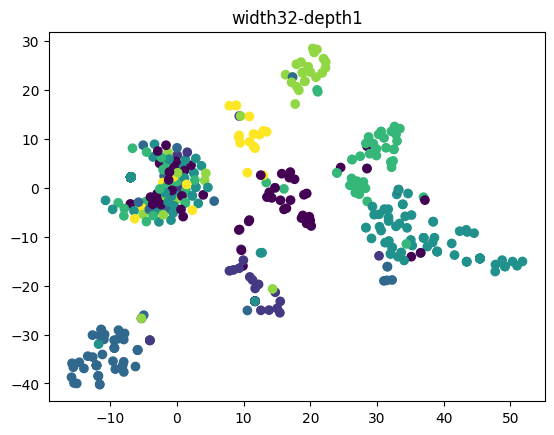

starting experiment 1
starting split 0
using cpu
starting split 1
using cpu
starting split 2
using cpu
starting split 3
using cpu
starting split 4
using cpu
starting split 5
using cpu
starting split 6
using cpu
starting split 7
using cpu
starting split 8
using cpu
starting split 9
using cpu


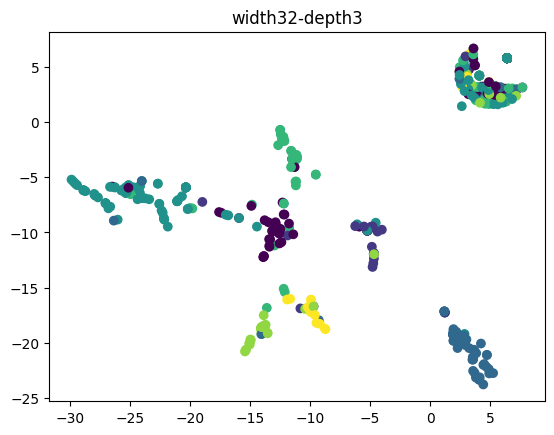

starting experiment 2
starting split 0
using cpu
starting split 1
using cpu
starting split 2
using cpu
starting split 3
using cpu
starting split 4
using cpu
starting split 5
using cpu
starting split 6
using cpu
starting split 7
using cpu
starting split 8
using cpu
starting split 9
using cpu


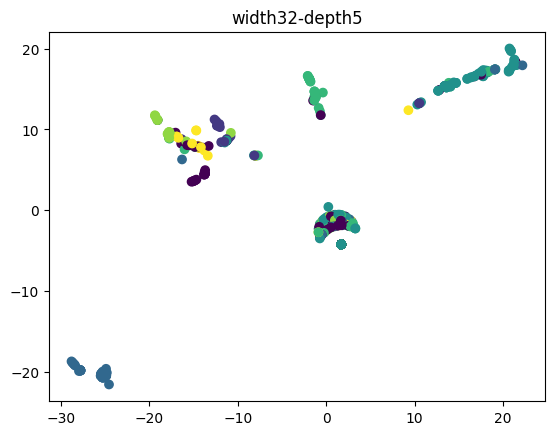

starting experiment 3
starting split 0
using cpu
starting split 1
using cpu
starting split 2
using cpu
starting split 3
using cpu
starting split 4
using cpu
starting split 5
using cpu
starting split 6
using cpu
starting split 7
using cpu
starting split 8
using cpu
starting split 9
using cpu


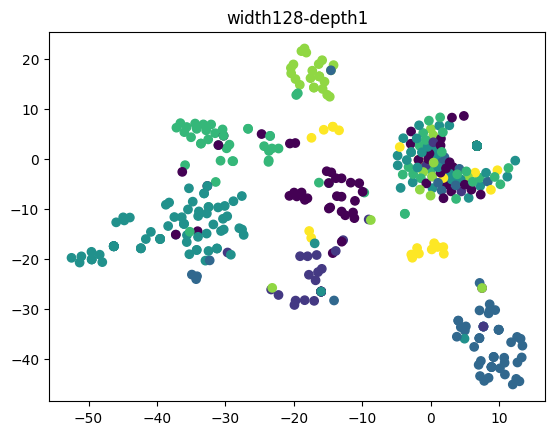

starting experiment 4
starting split 0
using cpu
starting split 1
using cpu
starting split 2
using cpu
starting split 3
using cpu
starting split 4
using cpu
starting split 5
using cpu
starting split 6
using cpu
starting split 7
using cpu
starting split 8
using cpu
starting split 9
using cpu


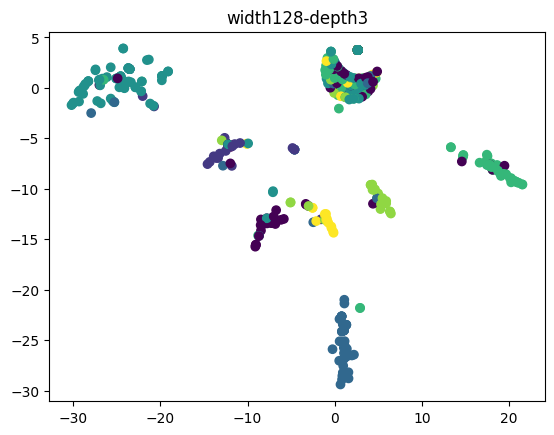

starting experiment 5
starting split 0
using cpu
starting split 1
using cpu
starting split 2
using cpu
starting split 3
using cpu
starting split 4
using cpu
starting split 5
using cpu
starting split 6
using cpu
starting split 7
using cpu
starting split 8
using cpu
starting split 9
using cpu


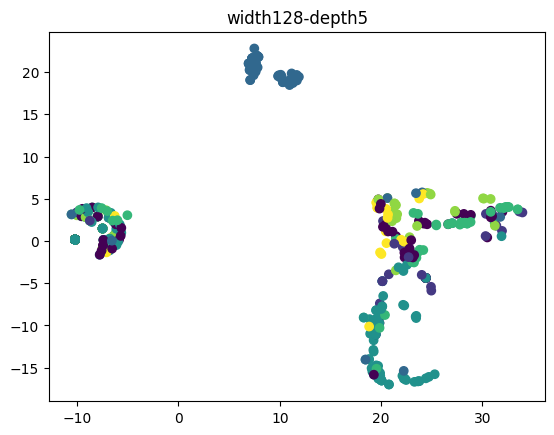

starting experiment 6
starting split 0
using cpu
starting split 1
using cpu
starting split 2
using cpu
starting split 3
using cpu
starting split 4
using cpu
starting split 5
using cpu
starting split 6
using cpu
starting split 7
using cpu
starting split 8
using cpu
starting split 9
using cpu


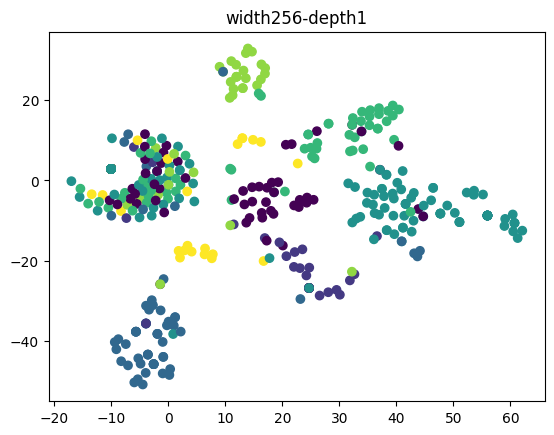

starting experiment 7
starting split 0
using cpu
starting split 1
using cpu
starting split 2
using cpu
starting split 3
using cpu
starting split 4
using cpu
starting split 5
using cpu
starting split 6
using cpu
starting split 7
using cpu
starting split 8
using cpu
starting split 9
using cpu


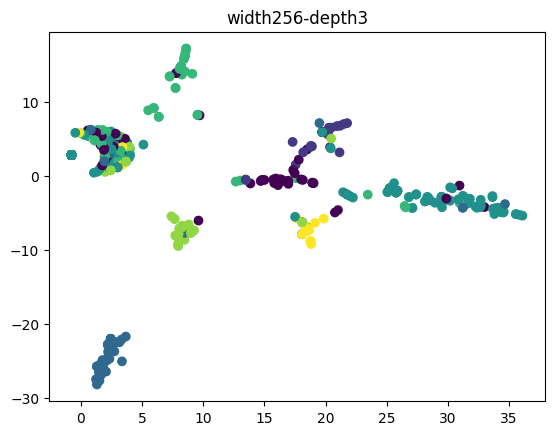

starting experiment 8
starting split 0
using cpu
starting split 1
using cpu
starting split 2
using cpu
starting split 3
using cpu
starting split 4
using cpu
starting split 5
using cpu
starting split 6
using cpu
starting split 7
using cpu
starting split 8
using cpu
starting split 9
using cpu


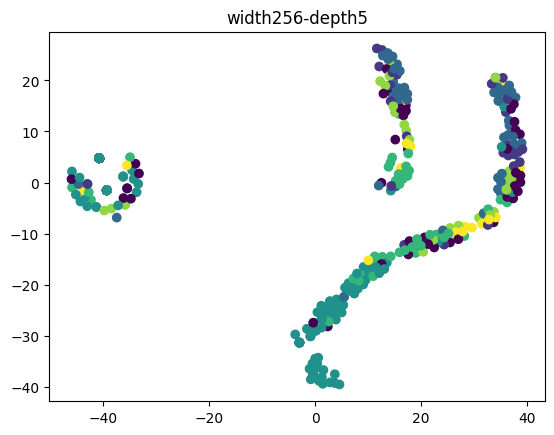

In [147]:

def run_experiment(ginparams, hyperparams, dataset, verbose=False):
    device = get_device()
    model = CustomGIN(ginparams)
    optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
    train_acc, val_acc = train_model(model, dataset, optimizer, device, hyperparams, verbose=verbose)
    test_acc = test_model(model, dataset)
    return model, train_acc, val_acc, test_acc

def plot_model_embeddings(df, title):
    plt.scatter(df[0], df[1], c=df["label"])
    plt.title(title)
    plt.show()



hyperparams = {
    "max_epochs": 200,
    "learning_rate": 0.01,
    "weight_decay": 0.05,
    "early_stopping_bad_epochs": 5,
}


experiments = []
widths = [32, 128, 256]
depths = [1, 3, 5]
for width in widths:
    for depth in depths:
        ginparams = {
            "num_hidden_gin_layers": 1, # 2 in total
            "gin_input_dim": cora_dataset.x.shape[1],
            "gin_hidden_dim": 32,
            "num_hidden_mlp_layers": depth,
            "mlp_hidden_dim": width,
            "output_dim": len(torch.unique(cora_dataset.y)),
        }
        experiment = (ginparams, hyperparams)
        experiments.append(experiment)

experiment_result = {
    "name": "y MLPwidth z MLPdepth",
    "MLPwidth": 0,
    "MLPdepth": 0,
    "train_acc_mean": 0,
    "train_acc_std": 0,
    "val_acc_mean": 0,
    "val_acc_std": 0,
    "test_acc_mean": 0,
    "test_acc_std": 0,
    "best_model_embedding_df": 0,
}

num_splits = 10
train_val_ratio = 0.75
experiment_results = []
train_accs = []
val_accs = []
test_accs = []

train_masks = []
val_masks = []
for i in range(num_splits):
    train_mask, val_mask = split_mask(cora_dataset.dev_mask, train_val_ratio)
    train_masks.append(train_mask)
    val_masks.append(val_mask)


for i in range(len(experiments)):
    best_model = "N/A"
    best_test_acc = 0
    ginparams, hyperparams = experiments[i]
    print(f"starting experiment {i}")
    for j in range(num_splits):
        print(f"starting split {j}")
        train_mask = train_masks[j]
        val_mask = val_masks[j]
        cora_dataset.train_mask = train_mask
        cora_dataset.val_mask = val_mask
        model, train_acc, val_acc, test_acc = run_experiment(ginparams, hyperparams, cora_dataset)
        if test_acc > best_test_acc:
            best_model = copy.deepcopy(model)
            best_test_acc = test_acc
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    w, d = ginparams["mlp_hidden_dim"], ginparams["num_hidden_mlp_layers"]
    experiment_result["name"] = f"width{w}-depth{d}"
    experiment_result["MLPwidth"] = w
    experiment_result["MLPdepth"] = d
    experiment_result["train_acc_mean"] = float(np.mean(train_accs))
    experiment_result["train_acc_std"] = float(np.std(train_accs))
    experiment_result["val_acc_mean"] = float(np.mean(val_accs))
    experiment_result["val_acc_std"] = float(np.std(val_accs))
    experiment_result["test_acc_mean"] = float(np.mean(test_accs))
    experiment_result["test_acc_std"] = float(np.std(test_accs))
    experiment_result["best_model_embedding_df"] = dimension_reduction(best_model, cora_dataset)
    experiment_results.append(copy.deepcopy(experiment_result))
    plot_model_embeddings(experiment_result["best_model_embedding_df"], experiment_result["name"])




In [114]:
def experiments_to_df(experiment_results):
    ignore_keys = ["best_model_embedding_df"]
    filtered_data = [{k: v for k, v in d.items() if k not in ignore_keys} for d in experiment_results]
    df = pd.DataFrame(filtered_data)
    return df

In [157]:
pd.set_option('display.float_format', '{:.3f}'.format)
df = experiments_to_df(experiment_results)
df = df.applymap(lambda x: round(x, 3) if isinstance(x, float) else x)
df.drop(columns=["GINLayers"]) # not relevant, comment out if error

,name,MLPwidth,MLPdepth,train_acc_mean,train_acc_std,val_acc_mean,val_acc_std,test_acc_mean,test_acc_std
0,width32-depth1,32,1,0.976,0.006,0.727,0.029,0.770,0.013
1,width32-depth3,32,3,0.942,0.035,0.688,0.069,0.729,0.056
2,width32-depth5,32,5,0.884,0.094,0.659,0.087,0.700,0.077
3,width128-depth1,128,1,0.907,0.091,0.676,0.083,0.716,0.073
4,width128-depth3,128,3,0.913,0.082,0.667,0.089,0.708,0.080
5,width128-depth5,128,5,0.862,0.156,0.620,0.140,0.656,0.146
6,width256-depth1,256,1,0.878,0.149,0.636,0.136,0.673,0.142
7,width256-depth3,256,3,0.886,0.141,0.627,0.135,0.665,0.140
8,width256-depth5,256,5,0.852,0.167,0.594,0.158,0.629,0.166


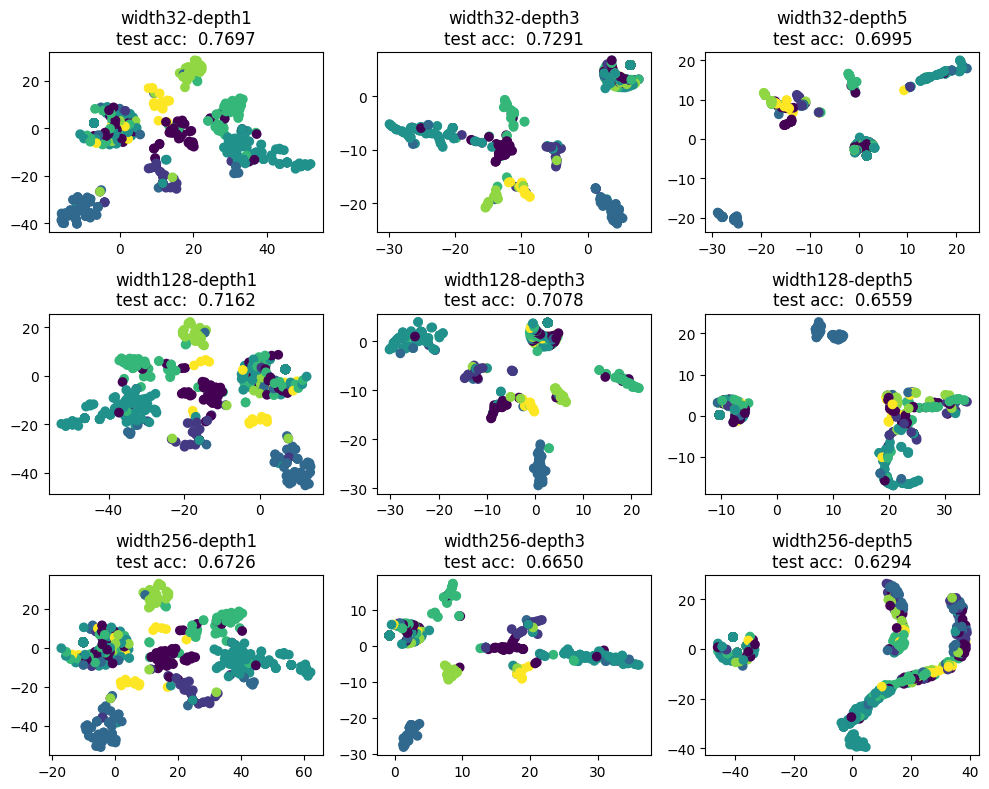

In [149]:

def experiments_to_plot(experiment_results):
    fig, axes = plt.subplots(len(widths), (len(depths)), figsize=(10, 8))

    for i, row in enumerate(widths):
        for j, col in enumerate(depths):
            experiment = experiment_results[i*len(widths)+j]
            df = experiment["best_model_embedding_df"]
            axes[i, j].scatter(df[0], df[1], c=df["label"])
            test_acc = experiment["test_acc_mean"]
            axes[i, j].set_title(experiment["name"]+f"\ntest acc:  {test_acc:.4f}")

    plt.tight_layout()
    plt.show()

experiments_to_plot(experiment_results)

# Chameleon GIN training (TOO UNSTABLE)

In [146]:
ginparams = {
    "num_hidden_gin_layers": 2,
    "gin_input_dim": chameleon_dataset.x.shape[1],
    "gin_hidden_dim": 128,
    "num_hidden_mlp_layers": 1,
    "mlp_hidden_dim": 128,
    "output_dim": len(torch.unique(chameleon_dataset.y)),
}

hyperparams = {
    "max_epochs": 150,
    "learning_rate": 0.02,
    "weight_decay": 0.01,
    "early_stopping_bad_epochs": 5,
}
device = get_device()
model = CustomGIN(ginparams)
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
scheduler = None
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
train_model(model, chameleon_dataset, optimizer, device, hyperparams, verbose=True, scheduler=scheduler)
test_model(model, chameleon_dataset)

using cpu
epoch: 1, train_loss: 19.154285430908203, train_acc: 0.22344322344322345, val_acc: 0.22908093278463648
epoch: 2, train_loss: 1342.890625, train_acc: 0.23534798534798534, val_acc: 0.1755829903978052
epoch: 3, train_loss: 19811.4453125, train_acc: 0.15384615384615385, val_acc: 0.2551440329218107
epoch: 4, train_loss: 26795.39453125, train_acc: 0.2216117216117216, val_acc: 0.18655692729766804
epoch: 5, train_loss: 21980.20703125, train_acc: 0.21703296703296704, val_acc: 0.1728395061728395
epoch: 6, train_loss: 7697.43017578125, train_acc: 0.19322344322344323, val_acc: 0.2729766803840878
epoch: 7, train_loss: 5242.73828125, train_acc: 0.260989010989011, val_acc: 0.18106995884773663
epoch: 8, train_loss: 12611.6650390625, train_acc: 0.1684981684981685, val_acc: 0.16186556927297668
epoch: 9, train_loss: 4738.9970703125, train_acc: 0.15934065934065933, val_acc: 0.19753086419753085
epoch: 10, train_loss: 1840.748046875, train_acc: 0.2078754578754579, val_acc: 0.18518518518518517
epoc

0.21710526315789475